In [2]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt


from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [3]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0
nfreq = 1

In [161]:
tag_bot = 0.5
tag_side = 4
tsio2 = 4
monitor_position = 0.5 * 2
monitor_blank = 0.5 * 0.1
tpml = 0.4

width_ag = 0.2
width_sio2 = 2
width_bot_ag = round(width_ag + width_sio2 + width_ag,2)
design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

# 시뮬레이션 셀 크기
Sx = tpml + width_bot_ag + tpml
Sy = round(tpml + tag_bot + tag_side + design_region_height + monitor_position + monitor_blank + tpml, 3)
cell_size = mp.Vector3(Sx, Sy)

# 재료
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

# 디자인 변수 격자
Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1
# Ny = 1


# 위치 계산
y_bottom = -Sy / 2
center_y_ag = y_bottom + tpml + tag_bot / 2
center_y_sio2 = y_bottom + tpml + tag_bot + tsio2 / 2
center_y_design = y_bottom + tpml + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tpml + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tpml + tag_bot + 1 / fcen
center_Ag_x_position = design_region_width / 2 - width_ag / 2

boundary_layers = [
    mp.Absorber(tpml, direction=mp.X),
    mp.PML(tpml, direction=mp.Y)
]

In [162]:
# 셀 크기 설정
decom_size = width_bot_ag
# cell_size = mp.Vector3(decom_size, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [163]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )

        
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,

        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [164]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(0, center_y_monitor_position, 0)
    )
    for offset in offsets
]


k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag],
        # k_point=k0
    )
    for src in sources
]

In [165]:
monitor_position_J = mp.Vector3(0, center_y_source_position)
monitor_size = mp.Vector3(width_sio2-2/resolution, 0)

FourierFields_list = [
    mpa.FourierFields(
        sims[i],  
        mp.Volume(center=monitor_position_J, size=monitor_size),
        mp.Ez,
        yee_grid=True
    )
    for i in range(num_sources)
]

In [166]:
J = lambda fields : npa.sum(npa.abs(fields)**2, axis=1)

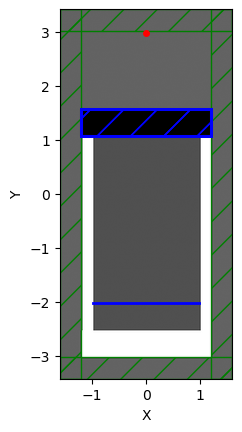

In [168]:
opt_list = [
    mpa.OptimizationProblem(
        simulation=sims[i],
        # objective_functions=[J0_02, J30_03, J45_05],
        objective_functions=[J],
        objective_arguments=[FourierFields_list[i]],
        design_regions=[design_region],  
        frequencies=[fcen],
        maximum_run_time=100,
    )
    for i in range(num_sources)
]
for i in range(num_sources):
    opt_list[i].plot2D(True)

In [169]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, warmup_iters=10):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.mt = None
        self.vt = None
        self.iter = 0
        self.warmup_iters = warmup_iters
        
    def reset_momenta(self):
        self.mt = None
        self.vt = None
        self.iter = 0
        
    def update(self, v, gradient):
        if self.mt is None:
            self.mt = np.zeros_like(v)
        if self.vt is None:
            self.vt = np.zeros_like(v)
            
            
        #Adam에서는 기울기 값과 기울기의 제곱값의 지수이동평균을 활용하여 step 변회량을 조절
        self.iter += 1
        self.mt = self.beta1 * self.mt + (1 - self.beta1) * gradient           #m_(t)=beta_(1)*m_(t-1)+(1-beta_(1))*gradient
        self.vt = self.beta2 * self.vt + (1 - self.beta2) * (gradient ** 2)       #v_(t)=beta_(2)*v_(t-1)+(1-beta_(2))*(gradeint^2)
         
        # 초기 몇번의 update에서 0으로 편향되어 있어서 출발 지점에서 멀리 떨어진 곳으로 이동하는, 초기 경로의 편향 문제를 해결 하기 위해 unbiased하게 만들어줌
        m_hat = self.mt / (1 - self.beta1 ** self.iter)   #m_hat=m/(1-beta1**t)
        v_hat = self.vt / (1 - self.beta2 ** self.iter)
        
        # Warm-up 단계
        if self.iter <= self.warmup_iters:
            warmup_factor = self.iter / self.warmup_iters
            lr = self.lr * warmup_factor
        else:
            lr = self.lr   #lr_t <- alpha*sqrt
            
        #update = self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        update_factor= m_hat / (np.sqrt(v_hat) + self.epsilon) #theta_t <- theta_(t-1)-alpha_(t)*m_(t)/(sqrt(v_(t))+epsilon) alpha_(t)=learning rate
        update = lr * update_factor
        updated_v = v + update
        updated_v = np.clip(updated_v, 0.0, 1.0)
        
        adam_lr=np.mean(np.abs(update))
        adam_uf=np.mean(np.abs(update_factor))
        
        # adam_beta1=self.beta1
        # # adam_beta2=self.beta2
        adam_m=self.mt
        adam_v=self.vt
        adam_t=self.iter
        
        return updated_v, adam_lr, adam_uf, adam_m, adam_v, adam_t

In [170]:
eta_i = 0.5

################ Nx * 1 grating desgin ################ 
def grating_mapping(x, eta, beta):    
    size_each = Nx * Ny

    v3 = x.reshape(layer_num, size_each)

    rho_list = []
    for i in range(layer_num):
        layer_field = v3[i].reshape(Nx, Ny)
        
        sym_field   = (layer_field[::-1, :] + layer_field) / 2
        flat        = sym_field.ravel()
        proj        = mpa.tanh_projection(flat, beta, eta)
        rho_list.append(proj)

    return npa.concatenate(rho_list, axis=0)

################ Nx * Ny freeform desgin ################ 
def free_mapping(x, eta, beta):
    size_each = Nx * Ny
    v3 = x.reshape(layer_num, size_each).reshape(layer_num, Nx, Ny)

    rho_list = []
    for i in range(layer_num):
        field = v3[i]                               
        proj  = mpa.tanh_projection(field, beta, eta)  
    
        proj = 0.5*(proj[::-1, :] + proj)   # x-축(좌우) 대칭
        rho_list.append(proj.ravel())

    return npa.concatenate(rho_list, axis=0)

In [171]:
############ Beta update ############
def update_beta(evaluation_history, binarization_history, beta):
    if len(evaluation_history) >= 3:
        f_prev2 = evaluation_history[-3]
        f_prev1 = evaluation_history[-2]
        f_curr  = evaluation_history[-1]

        bin_prev2 = binarization_history[-3]
        bin_prev1 = binarization_history[-2]
        bin_curr  = binarization_history[-1]

        change1 = abs(np.mean(f_curr)  - np.mean(f_prev1)) / (abs(np.mean(f_prev1)) + 1e-12)
        change2 = abs(np.mean(f_prev1) - np.mean(f_prev2)) / (abs(np.mean(f_prev2)) + 1e-12)

        bin_change1 = abs(bin_curr  - bin_prev1) / (abs(bin_prev1) + 1e-12)
        bin_change2 = abs(bin_prev1 - bin_prev2) / (abs(bin_prev2) + 1e-12)

        if (change1 < 0.005 and change2 < 0.005) and (bin_change1 < 0.001 and bin_change2 < 0.001):
            # if beta < 8:
            beta *= 1.2
            # else:
            # beta = beta + np.tanh((beta - 0.5)*0.02)
    return beta


--- Iter 1 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [1.7329110805028818]
Mean FoM: 1.732911
Binarization degree: 0.1328


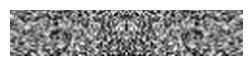


--- Iter 2 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2.1033664811557253]
Mean FoM: 2.103366
Binarization degree: 0.1332


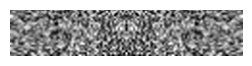


--- Iter 3 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [2.8685223174401084]
Mean FoM: 2.868522
Binarization degree: 0.1352


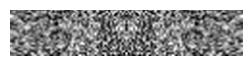


--- Iter 4 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [4.015783104569737]
Mean FoM: 4.015783
Binarization degree: 0.1394


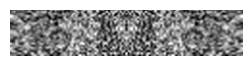


--- Iter 5 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [5.597265509162187]
Mean FoM: 5.597266
Binarization degree: 0.1467


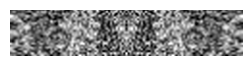


--- Iter 6 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [7.854766628718467]
Mean FoM: 7.854767
Binarization degree: 0.1575


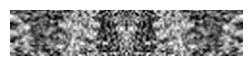


--- Iter 7 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [11.191583418775693]
Mean FoM: 11.191583
Binarization degree: 0.1718


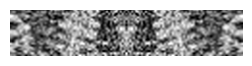


--- Iter 8 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [16.28517345034234]
Mean FoM: 16.285173
Binarization degree: 0.1895


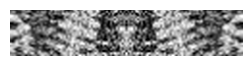


--- Iter 9 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [23.766781172691847]
Mean FoM: 23.766781
Binarization degree: 0.2110


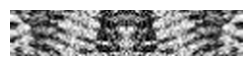


--- Iter 10 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [33.84750849887457]
Mean FoM: 33.847508
Binarization degree: 0.2365


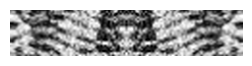


--- Iter 11 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [40.043036525460295]
Mean FoM: 40.043037
Binarization degree: 0.2659


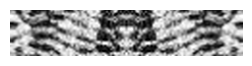


--- Iter 12 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [45.98934961655985]
Mean FoM: 45.989350
Binarization degree: 0.2940


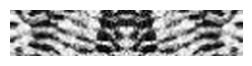


--- Iter 13 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [52.861273790815645]
Mean FoM: 52.861274
Binarization degree: 0.3195


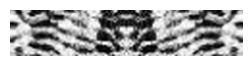


--- Iter 14 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [57.9046791903721]
Mean FoM: 57.904679
Binarization degree: 0.3427


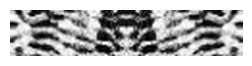


--- Iter 15 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [61.88853449443607]
Mean FoM: 61.888534
Binarization degree: 0.3642


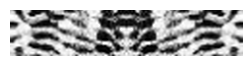


--- Iter 16 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [63.97598198413206]
Mean FoM: 63.975982
Binarization degree: 0.3841


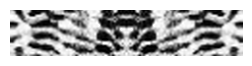


--- Iter 17 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [65.85904008221078]
Mean FoM: 65.859040
Binarization degree: 0.4021


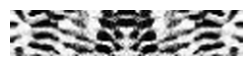


--- Iter 18 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [67.18213784095423]
Mean FoM: 67.182138
Binarization degree: 0.4180


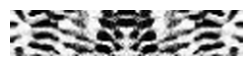


--- Iter 19 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [68.39798803821586]
Mean FoM: 68.397988
Binarization degree: 0.4324


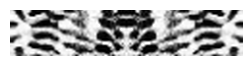


--- Iter 20 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [69.30156323514137]
Mean FoM: 69.301563
Binarization degree: 0.4457


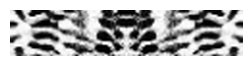


--- Iter 21 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [71.23970007718252]
Mean FoM: 71.239700
Binarization degree: 0.4574


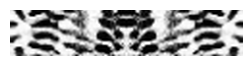


--- Iter 22 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [72.42414704090562]
Mean FoM: 72.424147
Binarization degree: 0.4679


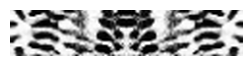


--- Iter 23 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [72.96454990425993]
Mean FoM: 72.964550
Binarization degree: 0.4769


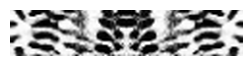


--- Iter 24 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [72.50327000494421]
Mean FoM: 72.503270
Binarization degree: 0.4857


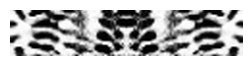


--- Iter 25 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [73.074020538365]
Mean FoM: 73.074021
Binarization degree: 0.4942


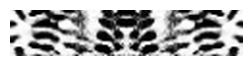


--- Iter 26 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [73.77364826210616]
Mean FoM: 73.773648
Binarization degree: 0.5024


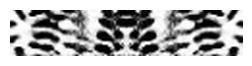


--- Iter 27 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [75.07022426281813]
Mean FoM: 75.070224
Binarization degree: 0.5101


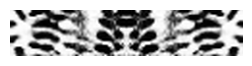


--- Iter 28 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [76.72777101338791]
Mean FoM: 76.727771
Binarization degree: 0.5174


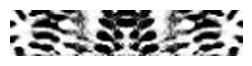


--- Iter 29 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [77.5677801111504]
Mean FoM: 77.567780
Binarization degree: 0.5245


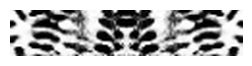


--- Iter 30 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [77.289451699663]
Mean FoM: 77.289452
Binarization degree: 0.5312


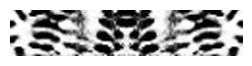


--- Iter 31 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [77.70931155544694]
Mean FoM: 77.709312
Binarization degree: 0.5373


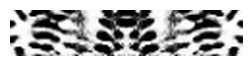


--- Iter 32 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [78.50626981104877]
Mean FoM: 78.506270
Binarization degree: 0.5427


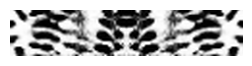


--- Iter 33 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [78.159121411342]
Mean FoM: 78.159121
Binarization degree: 0.5481


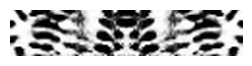


--- Iter 34 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [77.49151550936809]
Mean FoM: 77.491516
Binarization degree: 0.5536


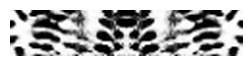


--- Iter 35 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [78.26021282477899]
Mean FoM: 78.260213
Binarization degree: 0.5587


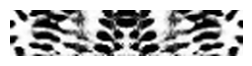


--- Iter 36 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [79.41945437522388]
Mean FoM: 79.419454
Binarization degree: 0.5632


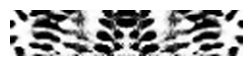


--- Iter 37 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [79.98698790544142]
Mean FoM: 79.986988
Binarization degree: 0.5674


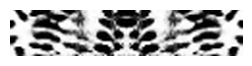


--- Iter 38 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [79.94787169306622]
Mean FoM: 79.947872
Binarization degree: 0.5715


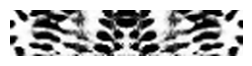


--- Iter 39 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [80.25616269939053]
Mean FoM: 80.256163
Binarization degree: 0.5753


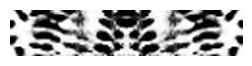


--- Iter 40 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [81.31424696228859]
Mean FoM: 81.314247
Binarization degree: 0.5791


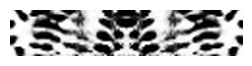


--- Iter 41 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [81.73214375172597]
Mean FoM: 81.732144
Binarization degree: 0.5826


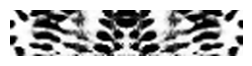


--- Iter 42 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [81.6648822408132]
Mean FoM: 81.664882
Binarization degree: 0.5861


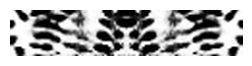


--- Iter 43 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [82.21657498606135]
Mean FoM: 82.216575
Binarization degree: 0.5893


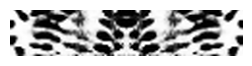


--- Iter 44 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [83.40686228165868]
Mean FoM: 83.406862
Binarization degree: 0.5922


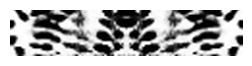


--- Iter 45 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [83.74059678588242]
Mean FoM: 83.740597
Binarization degree: 0.5954


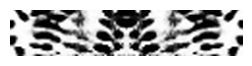


--- Iter 46 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [83.18420565151168]
Mean FoM: 83.184206
Binarization degree: 0.5985


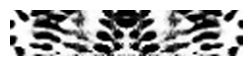


--- Iter 47 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [82.87156631228886]
Mean FoM: 82.871566
Binarization degree: 0.6010


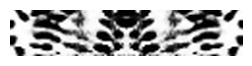


--- Iter 48 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [82.9670986386487]
Mean FoM: 82.967099
Binarization degree: 0.6034


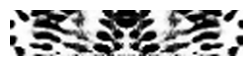


--- Iter 49 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [83.21371364291002]
Mean FoM: 83.213714
Binarization degree: 0.6059


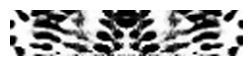


--- Iter 50 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [83.38245262977553]
Mean FoM: 83.382453
Binarization degree: 0.6084


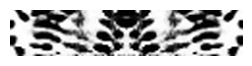


--- Iter 51 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [83.50844317312206]
Mean FoM: 83.508443
Binarization degree: 0.6109


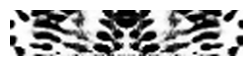


--- Iter 52 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [83.51685388892429]
Mean FoM: 83.516854
Binarization degree: 0.6129


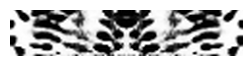


--- Iter 53 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [83.36832240369388]
Mean FoM: 83.368322
Binarization degree: 0.6150


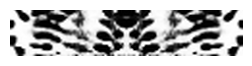


--- Iter 54 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [83.25236393566507]
Mean FoM: 83.252364
Binarization degree: 0.6172


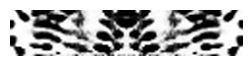


--- Iter 55 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [83.63024833444051]
Mean FoM: 83.630248
Binarization degree: 0.6191


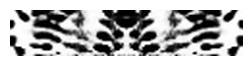


--- Iter 56 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [84.29839378947838]
Mean FoM: 84.298394
Binarization degree: 0.6207


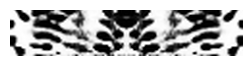


--- Iter 57 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [84.44000702587063]
Mean FoM: 84.440007
Binarization degree: 0.6225


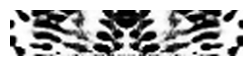


--- Iter 58 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [84.12715773713026]
Mean FoM: 84.127158
Binarization degree: 0.6244


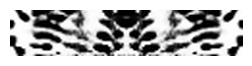


--- Iter 59 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [84.15447607516684]
Mean FoM: 84.154476
Binarization degree: 0.6261


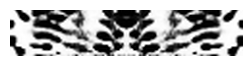


--- Iter 60 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [84.41090119203605]
Mean FoM: 84.410901
Binarization degree: 0.6276


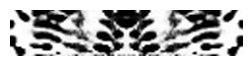


--- Iter 61 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [84.61393162406054]
Mean FoM: 84.613932
Binarization degree: 0.6294


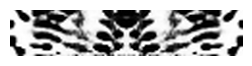


--- Iter 62 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [84.68955011067155]
Mean FoM: 84.689550
Binarization degree: 0.6313


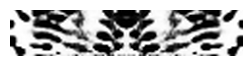


--- Iter 63 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [84.77925003473611]
Mean FoM: 84.779250
Binarization degree: 0.6329


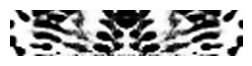


--- Iter 64 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [84.88725413812926]
Mean FoM: 84.887254
Binarization degree: 0.6343


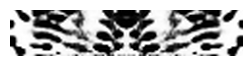


--- Iter 65 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.19753044575987]
Mean FoM: 85.197530
Binarization degree: 0.6360


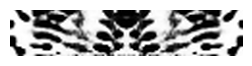


--- Iter 66 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.34053848550828]
Mean FoM: 85.340538
Binarization degree: 0.6380


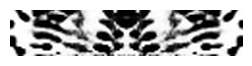


--- Iter 67 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.39082673278688]
Mean FoM: 85.390827
Binarization degree: 0.6395


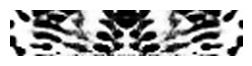


--- Iter 68 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.45124758102386]
Mean FoM: 85.451248
Binarization degree: 0.6408


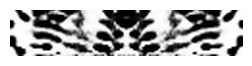


--- Iter 69 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.45301631691015]
Mean FoM: 85.453016
Binarization degree: 0.6424


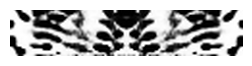


--- Iter 70 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.40998416346463]
Mean FoM: 85.409984
Binarization degree: 0.6446


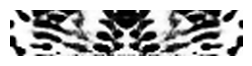


--- Iter 71 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.25685053915203]
Mean FoM: 85.256851
Binarization degree: 0.6464


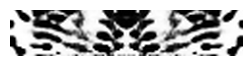


--- Iter 72 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [84.80692650135606]
Mean FoM: 84.806927
Binarization degree: 0.6478


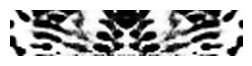


--- Iter 73 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [84.51909824538596]
Mean FoM: 84.519098
Binarization degree: 0.6493


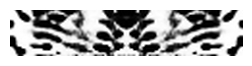


--- Iter 74 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.05887241704718]
Mean FoM: 85.058872
Binarization degree: 0.6511


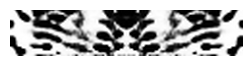


--- Iter 75 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.59302355793797]
Mean FoM: 85.593024
Binarization degree: 0.6526


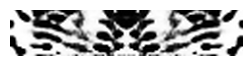


--- Iter 76 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.74051085093024]
Mean FoM: 85.740511
Binarization degree: 0.6538


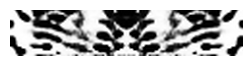


--- Iter 77 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.58156480256507]
Mean FoM: 85.581565
Binarization degree: 0.6550


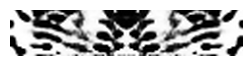


--- Iter 78 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.4191171206729]
Mean FoM: 85.419117
Binarization degree: 0.6564


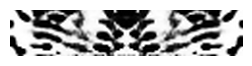


--- Iter 79 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.53246044859236]
Mean FoM: 85.532460
Binarization degree: 0.6576


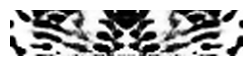


--- Iter 80 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.81330763868522]
Mean FoM: 85.813308
Binarization degree: 0.6587


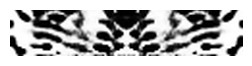


--- Iter 81 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [86.05324208011298]
Mean FoM: 86.053242
Binarization degree: 0.6599


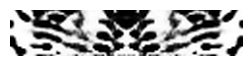


--- Iter 82 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [86.06632479333904]
Mean FoM: 86.066325
Binarization degree: 0.6612


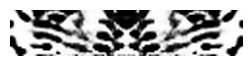


--- Iter 83 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.56960310475449]
Mean FoM: 85.569603
Binarization degree: 0.6622


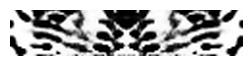


--- Iter 84 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.90115803137378]
Mean FoM: 85.901158
Binarization degree: 0.6634


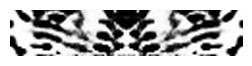


--- Iter 85 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [86.4575351285012]
Mean FoM: 86.457535
Binarization degree: 0.6650


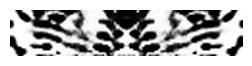


--- Iter 86 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [86.25181020438667]
Mean FoM: 86.251810
Binarization degree: 0.6663


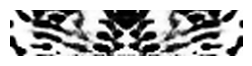


--- Iter 87 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.68624768011229]
Mean FoM: 85.686248
Binarization degree: 0.6682


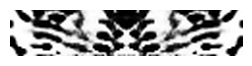


--- Iter 88 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [86.00075740173425]
Mean FoM: 86.000757
Binarization degree: 0.6703


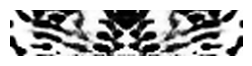


--- Iter 89 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [86.92392706024133]
Mean FoM: 86.923927
Binarization degree: 0.6727


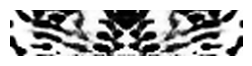


--- Iter 90 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.20686816051128]
Mean FoM: 87.206868
Binarization degree: 0.6746


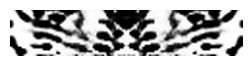


--- Iter 91 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.28923114313595]
Mean FoM: 87.289231
Binarization degree: 0.6761


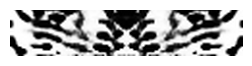


--- Iter 92 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [86.2837334746991]
Mean FoM: 86.283733
Binarization degree: 0.6772


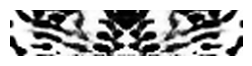


--- Iter 93 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.39534642957462]
Mean FoM: 85.395346
Binarization degree: 0.6785


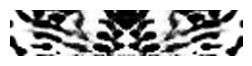


--- Iter 94 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.62295739176285]
Mean FoM: 85.622957
Binarization degree: 0.6801


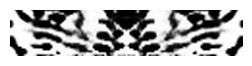


--- Iter 95 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [86.76866558635746]
Mean FoM: 86.768666
Binarization degree: 0.6818


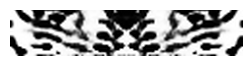


--- Iter 96 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.86978073286556]
Mean FoM: 87.869781
Binarization degree: 0.6831


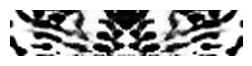


--- Iter 97 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.98088519233005]
Mean FoM: 87.980885
Binarization degree: 0.6839


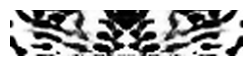


--- Iter 98 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.63041854314713]
Mean FoM: 87.630419
Binarization degree: 0.6848


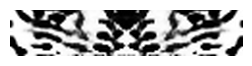


--- Iter 99 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.14440864887328]
Mean FoM: 87.144409
Binarization degree: 0.6858


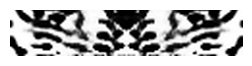


--- Iter 100 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [86.2886236947859]
Mean FoM: 86.288624
Binarization degree: 0.6869


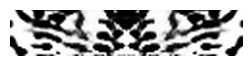


--- Iter 101 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.86119729487666]
Mean FoM: 85.861197
Binarization degree: 0.6878


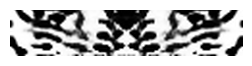


--- Iter 102 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [86.34951186752967]
Mean FoM: 86.349512
Binarization degree: 0.6885


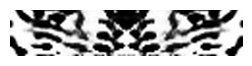


--- Iter 103 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.28512837546305]
Mean FoM: 87.285128
Binarization degree: 0.6891


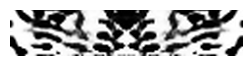


--- Iter 104 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.97463580029557]
Mean FoM: 87.974636
Binarization degree: 0.6896


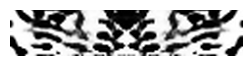


--- Iter 105 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.99800796793778]
Mean FoM: 87.998008
Binarization degree: 0.6903


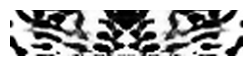


--- Iter 106 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.05586440219298]
Mean FoM: 88.055864
Binarization degree: 0.6911


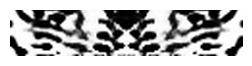


--- Iter 107 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.89680553694836]
Mean FoM: 87.896806
Binarization degree: 0.6919


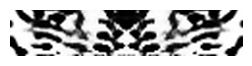


--- Iter 108 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [86.66624738377052]
Mean FoM: 86.666247
Binarization degree: 0.6926


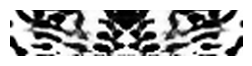


--- Iter 109 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.41292531511893]
Mean FoM: 85.412925
Binarization degree: 0.6934


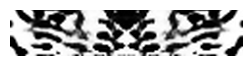


--- Iter 110 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [84.84823869848269]
Mean FoM: 84.848239
Binarization degree: 0.6940


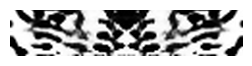


--- Iter 111 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [85.27048319806961]
Mean FoM: 85.270483
Binarization degree: 0.6946


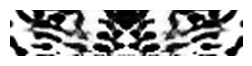


--- Iter 112 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.19609716995274]
Mean FoM: 87.196097
Binarization degree: 0.6953


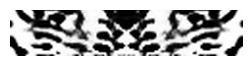


--- Iter 113 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.66391801813242]
Mean FoM: 88.663918
Binarization degree: 0.6961


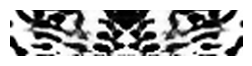


--- Iter 114 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.0128607980508]
Mean FoM: 89.012861
Binarization degree: 0.6970


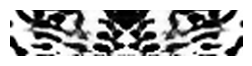


--- Iter 115 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.44241374508512]
Mean FoM: 88.442414
Binarization degree: 0.6979


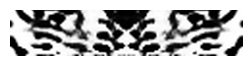


--- Iter 116 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.38549179514209]
Mean FoM: 87.385492
Binarization degree: 0.6987


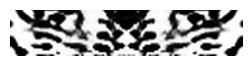


--- Iter 117 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [86.574747893631]
Mean FoM: 86.574748
Binarization degree: 0.6996


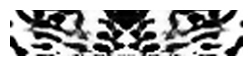


--- Iter 118 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [86.45809655728041]
Mean FoM: 86.458097
Binarization degree: 0.7007


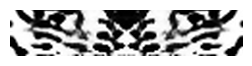


--- Iter 119 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.09355627940008]
Mean FoM: 87.093556
Binarization degree: 0.7020


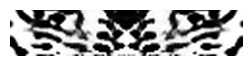


--- Iter 120 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.41966670078641]
Mean FoM: 88.419667
Binarization degree: 0.7034


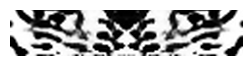


--- Iter 121 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.19857605588905]
Mean FoM: 89.198576
Binarization degree: 0.7045


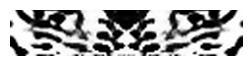


--- Iter 122 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.1964446208957]
Mean FoM: 89.196445
Binarization degree: 0.7057


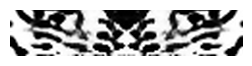


--- Iter 123 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.55303192495796]
Mean FoM: 88.553032
Binarization degree: 0.7069


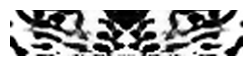


--- Iter 124 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.59049851175017]
Mean FoM: 87.590499
Binarization degree: 0.7082


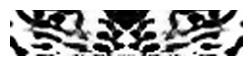


--- Iter 125 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.85001128834104]
Mean FoM: 87.850011
Binarization degree: 0.7098


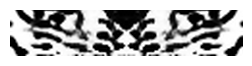


--- Iter 126 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.13773493220215]
Mean FoM: 88.137735
Binarization degree: 0.7112


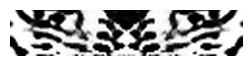


--- Iter 127 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.41007420888951]
Mean FoM: 88.410074
Binarization degree: 0.7125


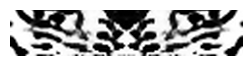


--- Iter 128 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.23225303001334]
Mean FoM: 88.232253
Binarization degree: 0.7135


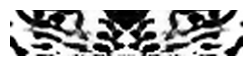


--- Iter 129 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.61594399882424]
Mean FoM: 87.615944
Binarization degree: 0.7144


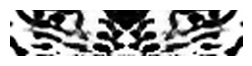


--- Iter 130 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.2282456246854]
Mean FoM: 87.228246
Binarization degree: 0.7154


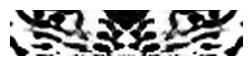


--- Iter 131 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.67341347532496]
Mean FoM: 87.673413
Binarization degree: 0.7163


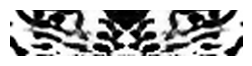


--- Iter 132 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.67460526480033]
Mean FoM: 88.674605
Binarization degree: 0.7171


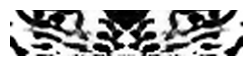


--- Iter 133 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.08730482440637]
Mean FoM: 89.087305
Binarization degree: 0.7181


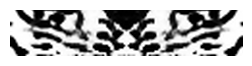


--- Iter 134 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.71425141257411]
Mean FoM: 88.714251
Binarization degree: 0.7193


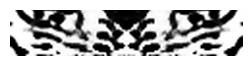


--- Iter 135 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.04097515795833]
Mean FoM: 88.040975
Binarization degree: 0.7202


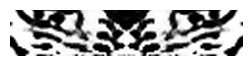


--- Iter 136 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.75367039134838]
Mean FoM: 87.753670
Binarization degree: 0.7210


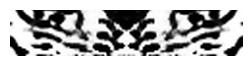


--- Iter 137 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.21598071034741]
Mean FoM: 88.215981
Binarization degree: 0.7218


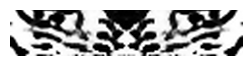


--- Iter 138 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.14570202058871]
Mean FoM: 89.145702
Binarization degree: 0.7229


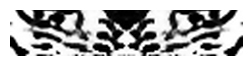


--- Iter 139 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.62681371670989]
Mean FoM: 89.626814
Binarization degree: 0.7239


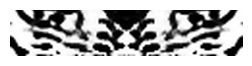


--- Iter 140 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.7430018890195]
Mean FoM: 88.743002
Binarization degree: 0.7251


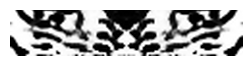


--- Iter 141 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.9027857785257]
Mean FoM: 87.902786
Binarization degree: 0.7264


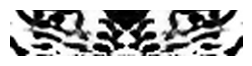


--- Iter 142 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.18180644183951]
Mean FoM: 88.181806
Binarization degree: 0.7276


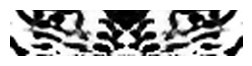


--- Iter 143 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.40233895975403]
Mean FoM: 89.402339
Binarization degree: 0.7287


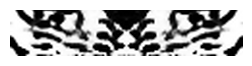


--- Iter 144 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.73965966832016]
Mean FoM: 89.739660
Binarization degree: 0.7297


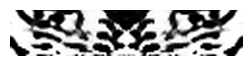


--- Iter 145 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.64513803631287]
Mean FoM: 88.645138
Binarization degree: 0.7307


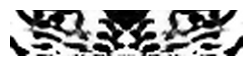


--- Iter 146 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [87.90834370746073]
Mean FoM: 87.908344
Binarization degree: 0.7315


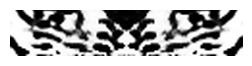


--- Iter 147 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.51242793855282]
Mean FoM: 88.512428
Binarization degree: 0.7321


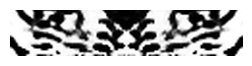


--- Iter 148 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.29086254624194]
Mean FoM: 89.290863
Binarization degree: 0.7327


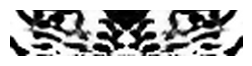


--- Iter 149 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.76010415637788]
Mean FoM: 89.760104
Binarization degree: 0.7335


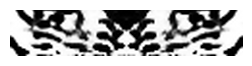


--- Iter 150 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.93653737161628]
Mean FoM: 88.936537
Binarization degree: 0.7342


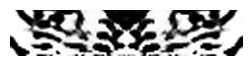


--- Iter 151 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.4787574487124]
Mean FoM: 88.478757
Binarization degree: 0.7350


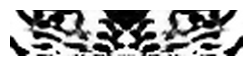


--- Iter 152 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.77562882710191]
Mean FoM: 88.775629
Binarization degree: 0.7355


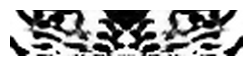


--- Iter 153 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.09020069086047]
Mean FoM: 89.090201
Binarization degree: 0.7361


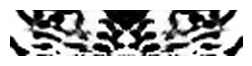


--- Iter 154 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.31861581138139]
Mean FoM: 89.318616
Binarization degree: 0.7365


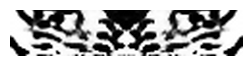


--- Iter 155 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.50490907485792]
Mean FoM: 89.504909
Binarization degree: 0.7370


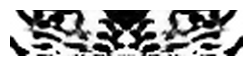


--- Iter 156 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.82203770903637]
Mean FoM: 89.822038
Binarization degree: 0.7376


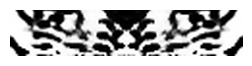


--- Iter 157 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.26737161897177]
Mean FoM: 90.267372
Binarization degree: 0.7382


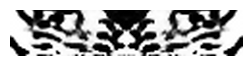


--- Iter 158 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.32696750982538]
Mean FoM: 90.326968
Binarization degree: 0.7390


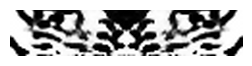


--- Iter 159 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.98185668420867]
Mean FoM: 89.981857
Binarization degree: 0.7397


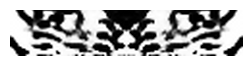


--- Iter 160 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.33051403408332]
Mean FoM: 89.330514
Binarization degree: 0.7405


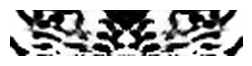


--- Iter 161 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.67432843722922]
Mean FoM: 89.674328
Binarization degree: 0.7414


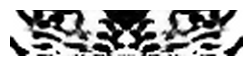


--- Iter 162 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.14673612460052]
Mean FoM: 90.146736
Binarization degree: 0.7421


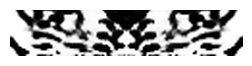


--- Iter 163 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.30116228272435]
Mean FoM: 90.301162
Binarization degree: 0.7427


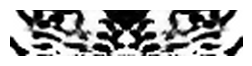


--- Iter 164 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.65907229368301]
Mean FoM: 89.659072
Binarization degree: 0.7432


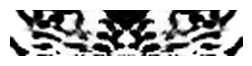


--- Iter 165 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.9285240393545]
Mean FoM: 88.928524
Binarization degree: 0.7437


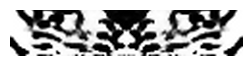


--- Iter 166 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.2023654099827]
Mean FoM: 89.202365
Binarization degree: 0.7443


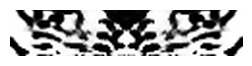


--- Iter 167 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.32736265141484]
Mean FoM: 90.327363
Binarization degree: 0.7447


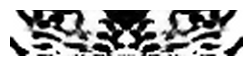


--- Iter 168 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.88191678802801]
Mean FoM: 90.881917
Binarization degree: 0.7453


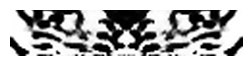


--- Iter 169 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.5416533646542]
Mean FoM: 90.541653
Binarization degree: 0.7460


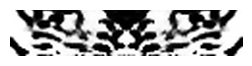


--- Iter 170 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.80833113525607]
Mean FoM: 89.808331
Binarization degree: 0.7467


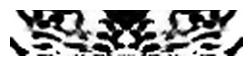


--- Iter 171 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.9040277015602]
Mean FoM: 89.904028
Binarization degree: 0.7475


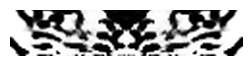


--- Iter 172 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.85935364074972]
Mean FoM: 89.859354
Binarization degree: 0.7484


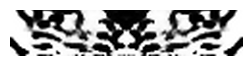


--- Iter 173 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.7254409873463]
Mean FoM: 89.725441
Binarization degree: 0.7491


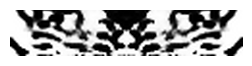


--- Iter 174 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.16343313103533]
Mean FoM: 90.163433
Binarization degree: 0.7494


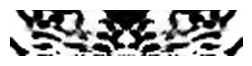


--- Iter 175 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.69075037437693]
Mean FoM: 90.690750
Binarization degree: 0.7495


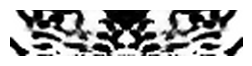


--- Iter 176 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.35459426537437]
Mean FoM: 90.354594
Binarization degree: 0.7497


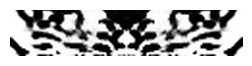


--- Iter 177 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.33066706614474]
Mean FoM: 90.330667
Binarization degree: 0.7504


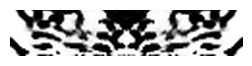


--- Iter 178 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.26451249164573]
Mean FoM: 90.264512
Binarization degree: 0.7508


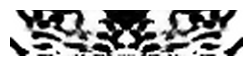


--- Iter 179 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.03533214251485]
Mean FoM: 90.035332
Binarization degree: 0.7507


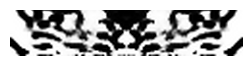


--- Iter 180 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.16654852643272]
Mean FoM: 91.166549
Binarization degree: 0.7507


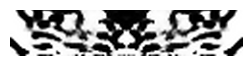


--- Iter 181 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.58752056883051]
Mean FoM: 91.587521
Binarization degree: 0.7508


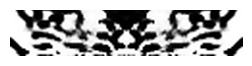


--- Iter 182 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.43200389922498]
Mean FoM: 90.432004
Binarization degree: 0.7511


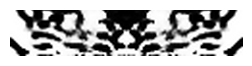


--- Iter 183 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.66059850376782]
Mean FoM: 89.660599
Binarization degree: 0.7514


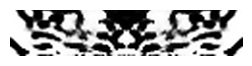


--- Iter 184 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.26428055816092]
Mean FoM: 90.264281
Binarization degree: 0.7516


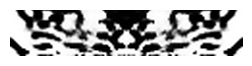


--- Iter 185 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.53738193879515]
Mean FoM: 91.537382
Binarization degree: 0.7516


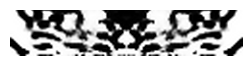


--- Iter 186 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.69148235978035]
Mean FoM: 91.691482
Binarization degree: 0.7517


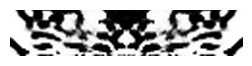


--- Iter 187 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.51214531183366]
Mean FoM: 90.512145
Binarization degree: 0.7520


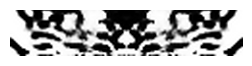


--- Iter 188 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.21997095542805]
Mean FoM: 90.219971
Binarization degree: 0.7523


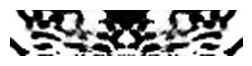


--- Iter 189 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.01441727470522]
Mean FoM: 91.014417
Binarization degree: 0.7525


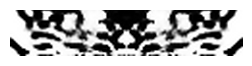


--- Iter 190 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.32369475749731]
Mean FoM: 91.323695
Binarization degree: 0.7528


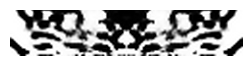


--- Iter 191 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.06508669829775]
Mean FoM: 91.065087
Binarization degree: 0.7530


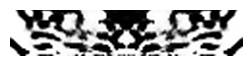


--- Iter 192 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.51390072247585]
Mean FoM: 90.513901
Binarization degree: 0.7531


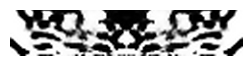


--- Iter 193 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.51402760628295]
Mean FoM: 90.514028
Binarization degree: 0.7533


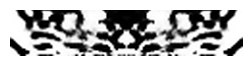


--- Iter 194 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.49325291578104]
Mean FoM: 91.493253
Binarization degree: 0.7536


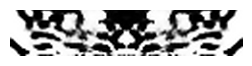


--- Iter 195 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.63237390984007]
Mean FoM: 91.632374
Binarization degree: 0.7540


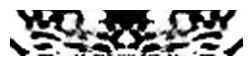


--- Iter 196 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.76367134930753]
Mean FoM: 90.763671
Binarization degree: 0.7543


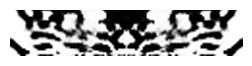


--- Iter 197 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.6367287445829]
Mean FoM: 90.636729
Binarization degree: 0.7542


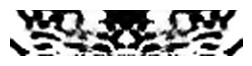


--- Iter 198 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.99247134974263]
Mean FoM: 90.992471
Binarization degree: 0.7540


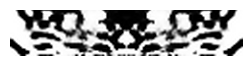


--- Iter 199 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.34328943371891]
Mean FoM: 91.343289
Binarization degree: 0.7540


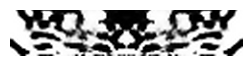


--- Iter 200 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.34333550011242]
Mean FoM: 91.343336
Binarization degree: 0.7543


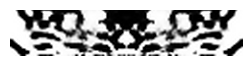


--- Iter 201 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.98017663488949]
Mean FoM: 90.980177
Binarization degree: 0.7547


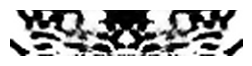


--- Iter 202 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.72542997088556]
Mean FoM: 90.725430
Binarization degree: 0.7552


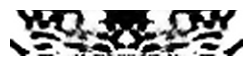


--- Iter 203 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.57039326787746]
Mean FoM: 91.570393
Binarization degree: 0.7553


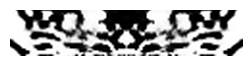


--- Iter 204 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.77389400428876]
Mean FoM: 91.773894
Binarization degree: 0.7554


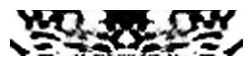


--- Iter 205 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.19550503277634]
Mean FoM: 91.195505
Binarization degree: 0.7557


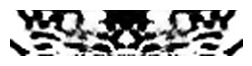


--- Iter 206 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.53861489503521]
Mean FoM: 90.538615
Binarization degree: 0.7561


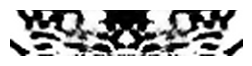


--- Iter 207 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.53793873643048]
Mean FoM: 91.537939
Binarization degree: 0.7564


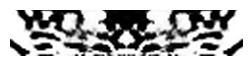


--- Iter 208 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.59669945326722]
Mean FoM: 91.596699
Binarization degree: 0.7566


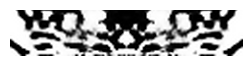


--- Iter 209 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.31656069533197]
Mean FoM: 90.316561
Binarization degree: 0.7567


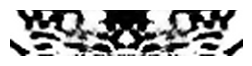


--- Iter 210 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.42571729001938]
Mean FoM: 90.425717
Binarization degree: 0.7566


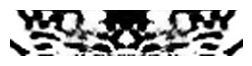


--- Iter 211 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.80828147515999]
Mean FoM: 91.808281
Binarization degree: 0.7566


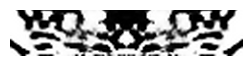


--- Iter 212 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.4218722234987]
Mean FoM: 91.421872
Binarization degree: 0.7566


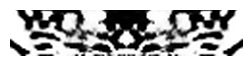


--- Iter 213 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.0018990426729]
Mean FoM: 90.001899
Binarization degree: 0.7565


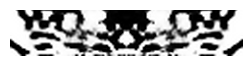


--- Iter 214 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.45930501027172]
Mean FoM: 90.459305
Binarization degree: 0.7564


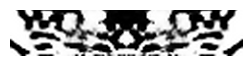


--- Iter 215 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.81905643173451]
Mean FoM: 91.819056
Binarization degree: 0.7565


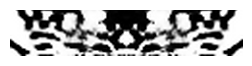


--- Iter 216 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.17523928088782]
Mean FoM: 91.175239
Binarization degree: 0.7566


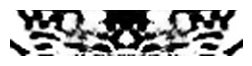


--- Iter 217 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.58108800796344]
Mean FoM: 90.581088
Binarization degree: 0.7565


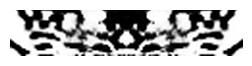


--- Iter 218 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.05143953034754]
Mean FoM: 91.051440
Binarization degree: 0.7566


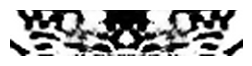


--- Iter 219 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.86868824684673]
Mean FoM: 90.868688
Binarization degree: 0.7569


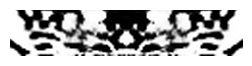


--- Iter 220 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.50414005099998]
Mean FoM: 91.504140
Binarization degree: 0.7570


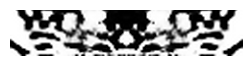


--- Iter 221 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.09972197444185]
Mean FoM: 91.099722
Binarization degree: 0.7570


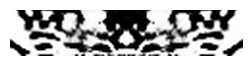


--- Iter 222 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.08388152944401]
Mean FoM: 90.083882
Binarization degree: 0.7574


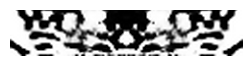


--- Iter 223 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.79907301324215]
Mean FoM: 91.799073
Binarization degree: 0.7580


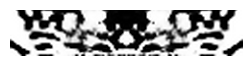


--- Iter 224 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.20933806959022]
Mean FoM: 91.209338
Binarization degree: 0.7587


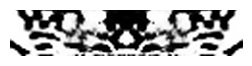


--- Iter 225 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.45105586103138]
Mean FoM: 90.451056
Binarization degree: 0.7593


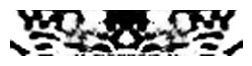


--- Iter 226 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.26345660868779]
Mean FoM: 91.263457
Binarization degree: 0.7601


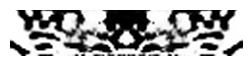


--- Iter 227 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [92.01261240678512]
Mean FoM: 92.012612
Binarization degree: 0.7613


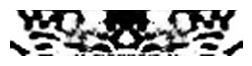


--- Iter 228 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.13799237277583]
Mean FoM: 91.137992
Binarization degree: 0.7627


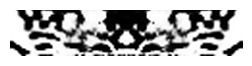


--- Iter 229 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.65916348958834]
Mean FoM: 90.659163
Binarization degree: 0.7636


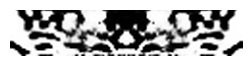


--- Iter 230 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.27067636597145]
Mean FoM: 91.270676
Binarization degree: 0.7649


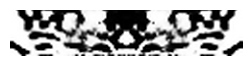


--- Iter 231 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.56020319388581]
Mean FoM: 91.560203
Binarization degree: 0.7662


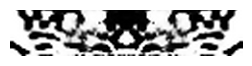


--- Iter 232 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.75957122154705]
Mean FoM: 91.759571
Binarization degree: 0.7673


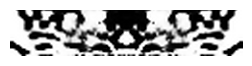


--- Iter 233 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.11804372964545]
Mean FoM: 90.118044
Binarization degree: 0.7682


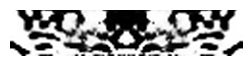


--- Iter 234 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.77711521759029]
Mean FoM: 90.777115
Binarization degree: 0.7691


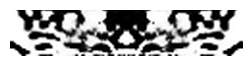


--- Iter 235 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.08029799441609]
Mean FoM: 91.080298
Binarization degree: 0.7702


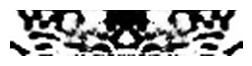


--- Iter 236 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.5704001516026]
Mean FoM: 91.570400
Binarization degree: 0.7709


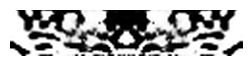


--- Iter 237 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.63742196072184]
Mean FoM: 90.637422
Binarization degree: 0.7714


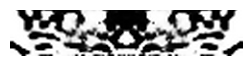


--- Iter 238 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.45735633998576]
Mean FoM: 90.457356
Binarization degree: 0.7719


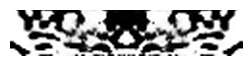


--- Iter 239 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.67804499929883]
Mean FoM: 90.678045
Binarization degree: 0.7727


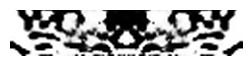


--- Iter 240 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.54609654712833]
Mean FoM: 90.546097
Binarization degree: 0.7735


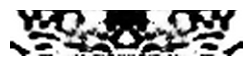


--- Iter 241 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.60833512639752]
Mean FoM: 91.608335
Binarization degree: 0.7740


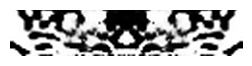


--- Iter 242 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.82722684081722]
Mean FoM: 90.827227
Binarization degree: 0.7745


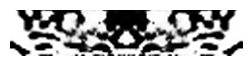


--- Iter 243 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.15892575591317]
Mean FoM: 90.158926
Binarization degree: 0.7752


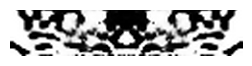


--- Iter 244 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.14324276210162]
Mean FoM: 90.143243
Binarization degree: 0.7761


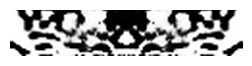


--- Iter 245 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.83315946689568]
Mean FoM: 90.833159
Binarization degree: 0.7768


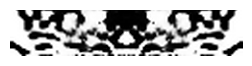


--- Iter 246 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.81533155911393]
Mean FoM: 91.815332
Binarization degree: 0.7774


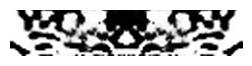


--- Iter 247 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.81861274220827]
Mean FoM: 90.818613
Binarization degree: 0.7780


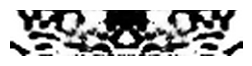


--- Iter 248 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.83812957207451]
Mean FoM: 89.838130
Binarization degree: 0.7787


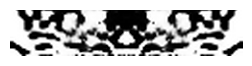


--- Iter 249 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.05999854770099]
Mean FoM: 90.059999
Binarization degree: 0.7793


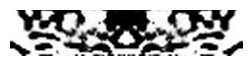


--- Iter 250 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.8328055841608]
Mean FoM: 90.832806
Binarization degree: 0.7799


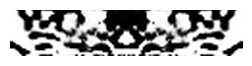


--- Iter 251 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.91893386138226]
Mean FoM: 91.918934
Binarization degree: 0.7805


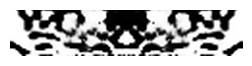


--- Iter 252 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.91256816956854]
Mean FoM: 90.912568
Binarization degree: 0.7812


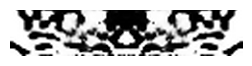


--- Iter 253 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.61218195736022]
Mean FoM: 89.612182
Binarization degree: 0.7817


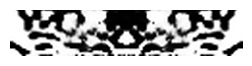


--- Iter 254 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.1572346134345]
Mean FoM: 90.157235
Binarization degree: 0.7821


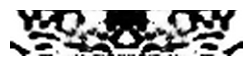


--- Iter 255 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.20036811556272]
Mean FoM: 91.200368
Binarization degree: 0.7824


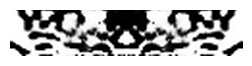


--- Iter 256 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.85882953073451]
Mean FoM: 91.858830
Binarization degree: 0.7829


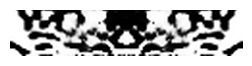


--- Iter 257 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.84101753682398]
Mean FoM: 90.841018
Binarization degree: 0.7834


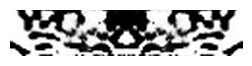


--- Iter 258 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.76114470296147]
Mean FoM: 89.761145
Binarization degree: 0.7837


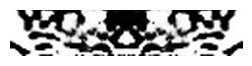


--- Iter 259 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.55340057438622]
Mean FoM: 90.553401
Binarization degree: 0.7840


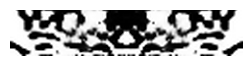


--- Iter 260 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.57862528377677]
Mean FoM: 91.578625
Binarization degree: 0.7844


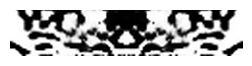


--- Iter 261 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.40414205679998]
Mean FoM: 91.404142
Binarization degree: 0.7848


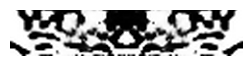


--- Iter 262 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.4483148781898]
Mean FoM: 90.448315
Binarization degree: 0.7852


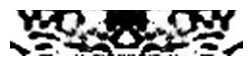


--- Iter 263 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.76417669689009]
Mean FoM: 90.764177
Binarization degree: 0.7853


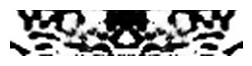


--- Iter 264 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.27623325675512]
Mean FoM: 91.276233
Binarization degree: 0.7855


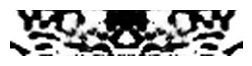


--- Iter 265 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [92.00691212910664]
Mean FoM: 92.006912
Binarization degree: 0.7857


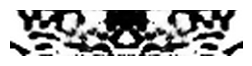


--- Iter 266 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.7141816327385]
Mean FoM: 89.714182
Binarization degree: 0.7862


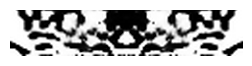


--- Iter 267 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.52172457619243]
Mean FoM: 90.521725
Binarization degree: 0.7863


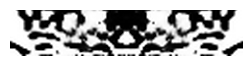


--- Iter 268 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [92.43349126417809]
Mean FoM: 92.433491
Binarization degree: 0.7863


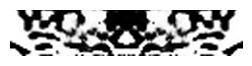


--- Iter 269 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.66287458068011]
Mean FoM: 91.662875
Binarization degree: 0.7866


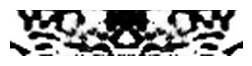


--- Iter 270 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.96913192059462]
Mean FoM: 90.969132
Binarization degree: 0.7870


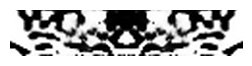


--- Iter 271 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.77927240169561]
Mean FoM: 90.779272
Binarization degree: 0.7874


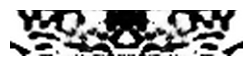


--- Iter 272 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.91137355241564]
Mean FoM: 90.911374
Binarization degree: 0.7875


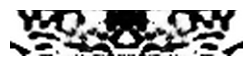


--- Iter 273 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [93.21060453523974]
Mean FoM: 93.210605
Binarization degree: 0.7873


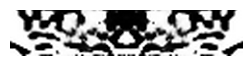


--- Iter 274 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.5906551199411]
Mean FoM: 91.590655
Binarization degree: 0.7874


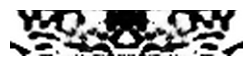


--- Iter 275 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.52644904892466]
Mean FoM: 89.526449
Binarization degree: 0.7878


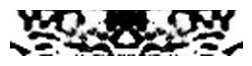


--- Iter 276 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.86829598461678]
Mean FoM: 91.868296
Binarization degree: 0.7879


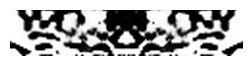


--- Iter 277 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [92.03191665597092]
Mean FoM: 92.031917
Binarization degree: 0.7881


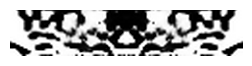


--- Iter 278 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.48707001599307]
Mean FoM: 89.487070
Binarization degree: 0.7882


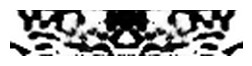


--- Iter 279 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [91.0402850971952]
Mean FoM: 91.040285
Binarization degree: 0.7881


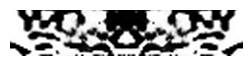


--- Iter 280 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [93.95398235020453]
Mean FoM: 93.953982
Binarization degree: 0.7880


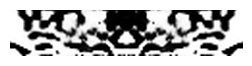


--- Iter 281 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [93.12485956889282]
Mean FoM: 93.124860
Binarization degree: 0.7883


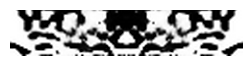


--- Iter 282 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.97930065574523]
Mean FoM: 88.979301
Binarization degree: 0.7888


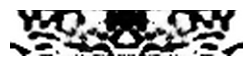


--- Iter 283 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.39231627486649]
Mean FoM: 89.392316
Binarization degree: 0.7891


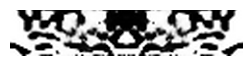


--- Iter 284 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [92.92742947251406]
Mean FoM: 92.927429
Binarization degree: 0.7890


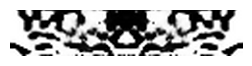


--- Iter 285 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [92.99887380985722]
Mean FoM: 92.998874
Binarization degree: 0.7893


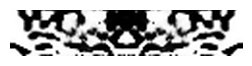


--- Iter 286 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.70922898187689]
Mean FoM: 88.709229
Binarization degree: 0.7899


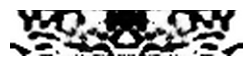


--- Iter 287 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [88.96906480977016]
Mean FoM: 88.969065
Binarization degree: 0.7902


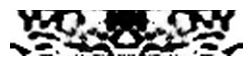


--- Iter 288 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [92.76004372025447]
Mean FoM: 92.760044
Binarization degree: 0.7904


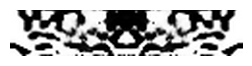


--- Iter 289 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [92.54774545125858]
Mean FoM: 92.547745
Binarization degree: 0.7908


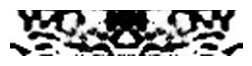


--- Iter 290 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.1376299165866]
Mean FoM: 89.137630
Binarization degree: 0.7913


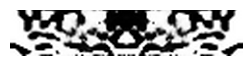


--- Iter 291 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.62218965212631]
Mean FoM: 89.622190
Binarization degree: 0.7916


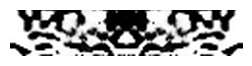


--- Iter 292 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [93.23546808759293]
Mean FoM: 93.235468
Binarization degree: 0.7916


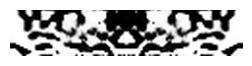


--- Iter 293 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [93.00837040711333]
Mean FoM: 93.008370
Binarization degree: 0.7920


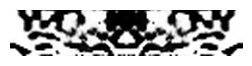


--- Iter 294 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [89.9497755222895]
Mean FoM: 89.949776
Binarization degree: 0.7926


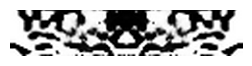


--- Iter 295 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.46924678802138]
Mean FoM: 90.469247
Binarization degree: 0.7928


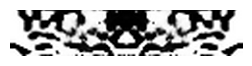


--- Iter 296 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [93.74149982172358]
Mean FoM: 93.741500
Binarization degree: 0.7929


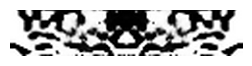


--- Iter 297 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [93.56128632349616]
Mean FoM: 93.561286
Binarization degree: 0.7932


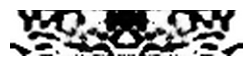


--- Iter 298 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.83470929860869]
Mean FoM: 90.834709
Binarization degree: 0.7938


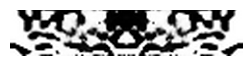


--- Iter 299 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [90.80095342880645]
Mean FoM: 90.800953
Binarization degree: 0.7941


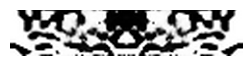


--- Iter 300 ---
Starting forward run...
Starting adjoint run...


Calculating gradient...
Current β: 4.000
FoM values: [93.37117319411705]
Mean FoM: 93.371173
Binarization degree: 0.7943


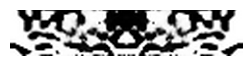

In [172]:
n = Nx * Ny
np.random.seed(4)           
x = 0.4 + 0.2 * np.random.rand(n)  
# x = np.ones(n)*0.5

cur_beta = 4

cur_iter             = [0]
evaluation_history   = []
beta_history         = []
binarization_history = []

g_histories   = [[] for _ in range(layer_num)]
x_histories   = [[] for _ in range(layer_num)]
lr_histories  = [[] for _ in range(layer_num)]
uf_histories  = [[] for _ in range(layer_num)]
t_histories   = [[] for _ in range(layer_num)]

# optimizers = [AdamOptimizer(lr=0.005, beta1=0.8) for _ in range(layer_num)]
optimizers = [AdamOptimizer(lr=0.02, beta1=0.9) for _ in range(layer_num)]

def f_multi(v, eta, beta):
    print(f"\n--- Iter {cur_iter[0]+1} ---")

    # β 전환 감지
    beta_changed = (len(beta_history) > 0 and beta != beta_history[-1])
    beta_prev = beta_history[-1] if beta_changed else beta

    # 현재/이전 β에서의 매핑
    rho_full = free_mapping(v, eta, beta)
    
    if beta_changed:
        rho_old = free_mapping(v, eta, beta_prev)

    # 이진화도 기록
    bin_deg = np.sum(np.abs(rho_full - 0.5)) / (0.5 * rho_full.size)
    binarization_history.append(bin_deg)

    size_each = Nx * Ny

    # --- FoM/그래디언트 계산: β 바뀐 경우 '값/민감도' 50:50 혼합 ---
    f0_list, dJ_list = [], []
    for i in range(len(opt_list)):
        if beta_changed:
            f_new, dJ_new = opt_list[i]([rho_full], need_value=True, need_gradient=True, beta=beta)
            f_old, dJ_old = opt_list[i]([rho_old],  need_value=True, need_gradient=True, beta=beta_prev)
            f0_list.append(0.5*(f_new.flatten() + f_old.flatten()))
            dJ_list.append(0.5*(dJ_new + dJ_old))
        else:
            f0_i, dJ_i = opt_list[i]([rho_full], need_value=True, need_gradient=True, beta=beta)
            f0_list.append(f0_i.flatten()); dJ_list.append(dJ_i)
        
    dJ_total = np.mean(dJ_list, axis=0) # -> 3번째 트라이 바꾸는 부분
    dJ_flat = np.array(dJ_total).flatten()

    if beta_changed:
        g_new = tensor_jacobian_product(free_mapping, 0)(v, eta, beta,      dJ_flat)
        g_old = tensor_jacobian_product(free_mapping, 0)(v, eta, beta_prev, dJ_flat)
        gradient_full = 0.5*(g_new + g_old)
    else:
        gradient_full = tensor_jacobian_product(free_mapping, 0)(v, eta, beta, dJ_flat)

    g_norm = np.linalg.norm(gradient_full.ravel()) / np.sqrt(gradient_full.size) + 1e-12
    gradient_full = gradient_full / g_norm

    grad_list = [gradient_full[i * size_each:(i + 1) * size_each] for i in range(layer_num)]
    vs = v.reshape(layer_num, size_each)
    v_new_layers = []
    
    for i in range(layer_num):
        vi_new, lr, uf, m, vt, t = optimizers[i].update(vs[i], grad_list[i])
        lr_histories[i].append(lr)
        uf_histories[i].append(uf)
        t_histories[i].append(t)
        g_histories[i].append(grad_list[i].copy())
        x_histories[i].append(vi_new.copy())
        v_new_layers.append(vi_new)

        if not hasattr(optimizers[i], "base_lr"):
            optimizers[i].base_lr = optimizers[i].lr
        if optimizers[i].lr < optimizers[i].base_lr:
            optimizers[i].lr = min(optimizers[i].base_lr, optimizers[i].lr * 1.25)

    v_new = np.concatenate(v_new_layers)

    f_vals = [float(np.abs(f0).item()) for f0 in f0_list]
    evaluation_history.append(f_vals)

    beta_history.append(beta)
    cur_iter[0] += 1

    update_beta(evaluation_history, binarization_history, beta)

    print(f"Current β: {beta:.3f}")
    print("FoM values:", f_vals)
    print(f"Mean FoM: {np.mean(f_vals):.6f}")
    print(f"Binarization degree: {bin_deg:.4f}")

    plt.figure(figsize=(3, 2))
    ax = plt.gca()
    opt_list[0].plot2D(
        False,
        output_plane=mp.Volume(
            size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
            center=mp.Vector3(0, full_center_y, 0)
        ),
        ax=ax,
        show_sources=False,
        show_monitors=False,
        show_boundary_layers=False,
    )
    ax.axis("off")
    plt.show()

    return v_new, beta

mp.verbosity(0)
Max_iter = 300

while cur_iter[0] < Max_iter:
    x, cur_beta = f_multi(x, eta_i, cur_beta)
    if binarization_history[-1] > 0.98:
        print("Threshold reached → final mapping with β=∞")
        # x, _ = f_multi(x, eta_i, np.inf)
        break

최대 FoM = 89.040997 는 iteration 91 에서 나왔습니다.


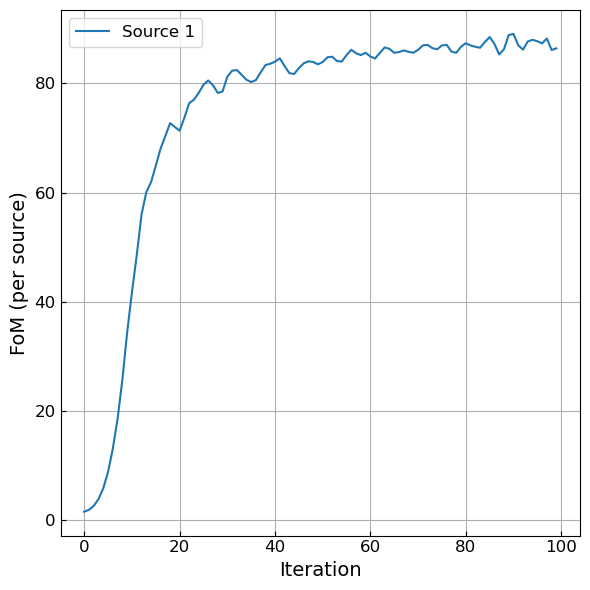

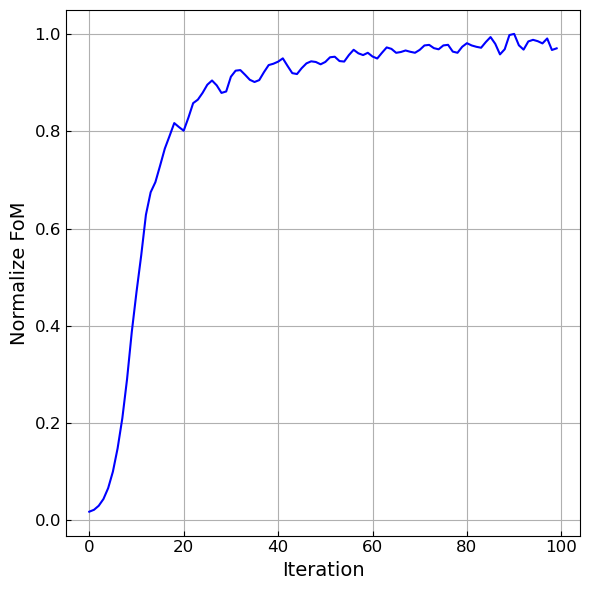

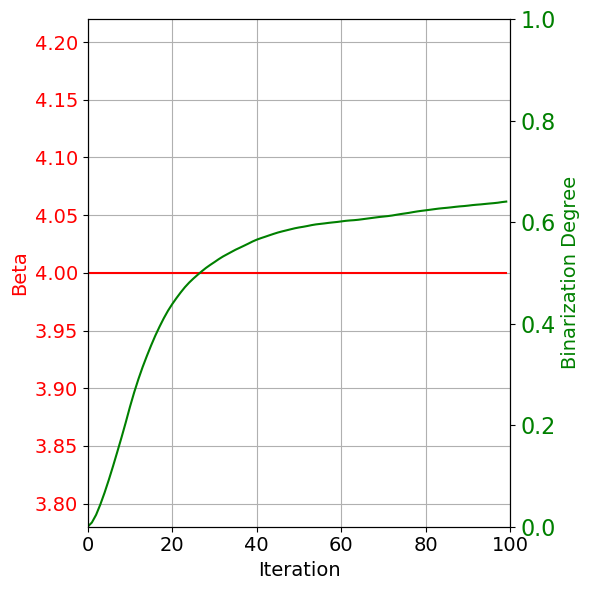

In [143]:
################ Find best FOM ################ 
eval_hist = np.array(evaluation_history)
max_val   = eval_hist.max()
max_idx0  = eval_hist.argmax()
iteration = max_idx0 + 1

print(f"최대 FoM = {max_val:.6f} 는 iteration {iteration} 에서 나왔습니다.")

################ FOM plot ################ 
evaluation_array = np.array(evaluation_history)  
iterations = np.arange(len(evaluation_history))

###################### [1] 각 소스별 FoM plot ######################
plt.figure(figsize=(6, 6))

for i in range(evaluation_array.shape[1]):  # 각 소스별
    plt.plot(iterations, evaluation_array[:, i], label=f"Source {i+1}")

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('FoM (per source)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

###################### [2] 평균 FoM plot ######################
plt.figure(figsize=(6, 6))

mean_fom = evaluation_array.mean(axis=1)  # 평균 FoM 계산
plt.plot(iterations, mean_fom/max(mean_fom), 'b-', label='Mean FoM')

plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Normalize FoM', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tick_params(direction='in')
plt.grid(True)
plt.tight_layout()
plt.show()

################ Combined Beta and Binarization Degree Plot ################ 
fig, ax1 = plt.subplots(figsize=(6,6))

color1 = 'red'
ax1.set_xlabel('Iteration', fontsize=14)
ax1.set_ylabel('Beta', color=color1, fontsize=14)
ax1.plot(beta_history, color=color1, label='Beta History')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xlim(0, np.array(cur_iter))
ax1.tick_params(labelsize=14)
ax1.grid(True)

ax2 = ax1.twinx()
color2 = 'green'
ax2.set_ylabel('Binarization Degree', color=color2, fontsize=14)
ax2.plot(binarization_history, color=color2, linestyle='-', label='Binarization Degree')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0.4, 1)
ax2.set_ylim(0, 1)
ax2.tick_params(labelsize=16)

fig.tight_layout()
# plt.title('Beta & Binarization Degree', fontsize=15)
plt.show()

In [153]:
# k = design_variables.weights
# np.savetxt("example.txt", k) 

k = np.loadtxt("example.txt")
opt_list[0].update_design([k])

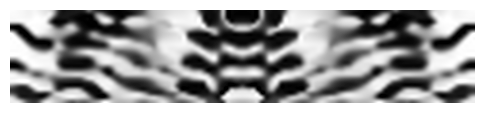

In [154]:
plt.figure(figsize=(6, 4))
ax = plt.gca()
opt_list[0].plot2D(
    False,
    output_plane=mp.Volume(
        size=mp.Vector3(design_region_width, region_height_each * layer_num - 1 / resolution, 0),
        center=mp.Vector3(0, full_center_y, 0)
    ),
    ax=ax,
    show_sources=False,
    show_monitors=False,
    show_boundary_layers=False,
)
ax.axis("off")
plt.show()

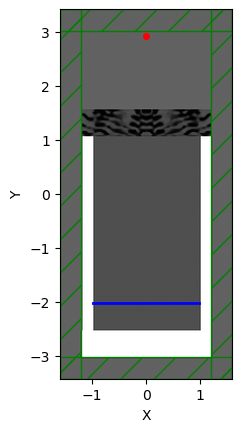

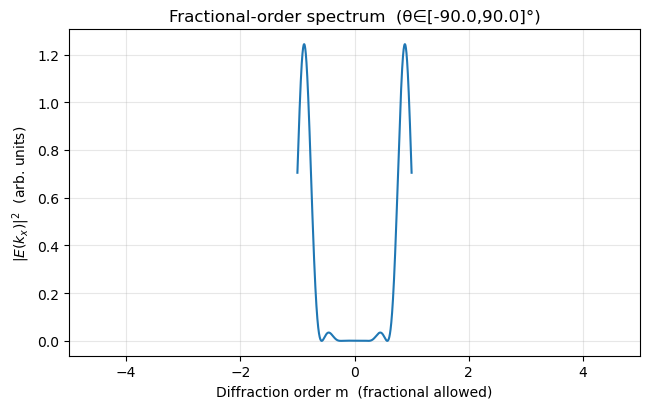

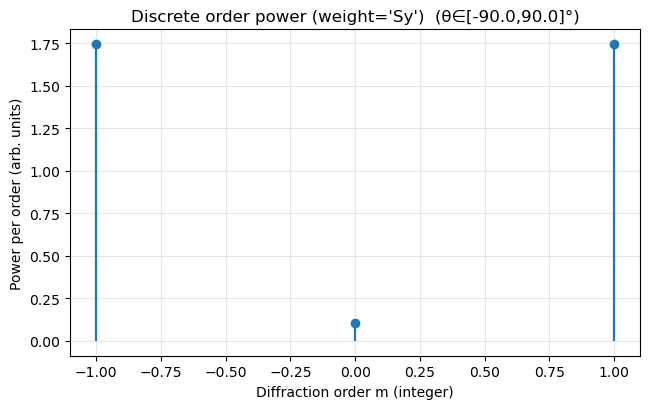

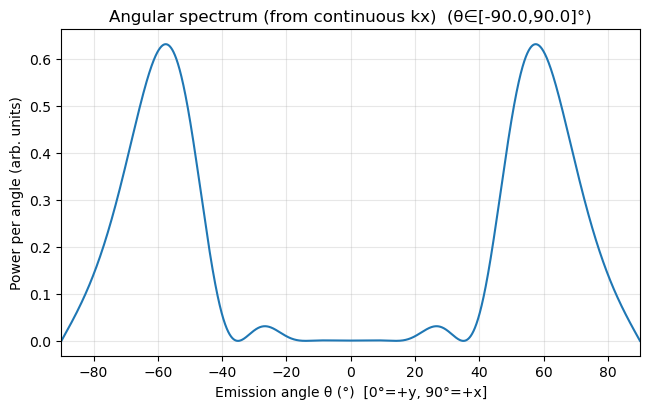

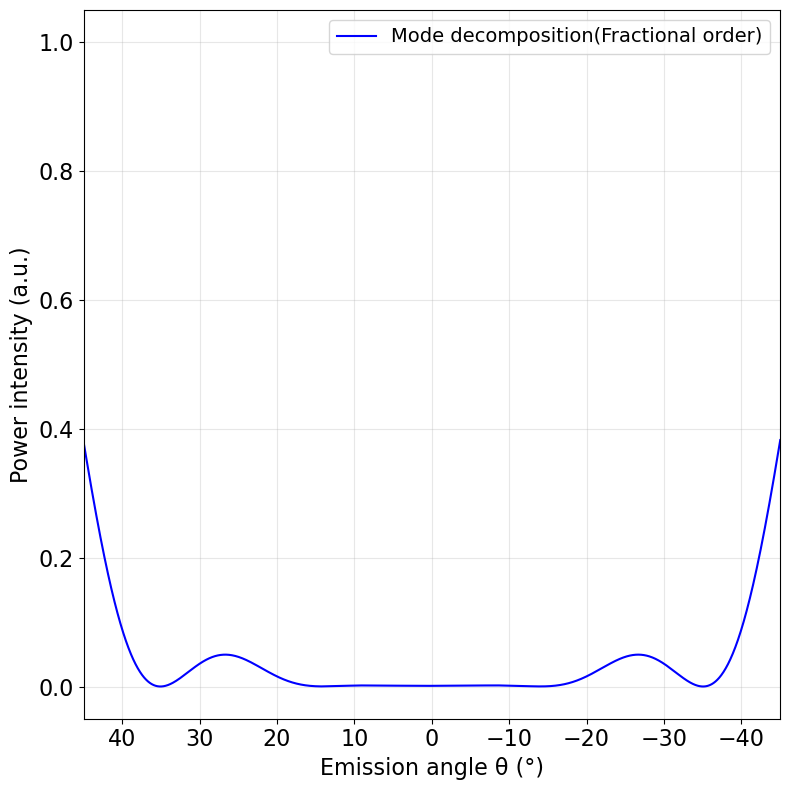

In [155]:
dft_monitor = opt_list[0].sim.add_dft_fields([mp.Ez], fcen,0,1, center = monitor_position_J, size = monitor_size, yee_grid=True)

opt_list[0].plot2D()

opt_list[0].sim.run(until=200)
Ez_dft = opt_list[0].sim.get_dft_array(dft_monitor,mp.Ez,0)

# ================= 물리적 회절차수 스펙트럼(분수/정수) + ANGLE MASK =================
import numpy as np
import matplotlib.pyplot as plt

# -------------------------- 사용자 입력 (예시/치환) --------------------------
# Ez_dft   = np.array(sim.get_dft_array(dft_top, mp.Ez, fi0))  # 이미 갖고 있다고 가정
# resolution = 50
# f0       = 1.429                      # 1/µm
# Lambda   = 1.0                        # µm, 예시

use_window   = True
win_kind     = 'tukey'                  # 'hann' or 'tukey'
tukey_alpha  = 0.25
Nkx          = 4001
weight       = 'Sy'                     # 'none' 또는 'Sy' (라인 윗면 법선 플럭스 가중)

# === ANGLE MASK ===
USE_ANGLE_MASK = True                  # False로 두면 마스크 비활성화
theta_min_deg  = -90                 # 보고 싶은 각도 범위(도)
theta_max_deg  = +90

# ------------------------------ 전처리 ------------------------------
Ez = Ez_dft.astype(np.complex128)
N  = len(Ez)
dx = 1.0 / float(resolution)

def make_window(N, kind='tukey', alpha=0.25):
    if kind.lower() in ['hann','hanning']:
        return np.hanning(N)
    if kind.lower() in ['tukey','tuk']:
        if alpha <= 0:  return np.ones(N)
        if alpha >= 1:  return np.hanning(N)
        n = np.arange(N)
        w = np.ones(N)
        edge = int(alpha*(N-1)/2.0)
        m = n[:edge+1]
        w[:edge+1] = 0.5*(1+np.cos(np.pi*(2*m/(alpha*(N-1)) - 1)))
        m = n[-(edge+1):]
        w[-(edge+1):] = 0.5*(1+np.cos(np.pi*(2*(m-(N-1))/(alpha*(N-1)) + 1)))
        return w
    return np.ones(N)

w = make_window(N, win_kind, tukey_alpha) if use_window else np.ones(N)

# 좌표는 중심 기준(위상 안정)
x      = (np.arange(N) - (N-1)/2) * dx
Ez_win = Ez * w

# ----------------------- 물리 상수/격자 파라미터 -----------------------
k0     = 2*np.pi*float(fcen)        # n=1 가정(Meep 기본 단위)
G      = 2*np.pi/float(1/fcen)    # 역격자 크기
m_max  = int(np.floor(k0/G + 1e-12))
m_list = np.arange(-m_max, m_max+1)

# -------------------- 연속 kx 그리드에서 직접 DFT --------------------
kx_grid = np.linspace(-k0, +k0, Nkx)     # 전파 성분 영역
Ckx     = dx * np.sum(Ez_win[:,None] * np.exp(-1j * x[:,None] * kx_grid), axis=0)
m_grid  = kx_grid / G

# === ANGLE MASK 생성 ===
theta_all = np.degrees(np.arcsin(np.clip(kx_grid/k0, -1, 1)))   # 0°=정면(+y), +90°=+x
if USE_ANGLE_MASK:
    ang_mask = (theta_all >= theta_min_deg) & (theta_all <= theta_max_deg)
else:
    ang_mask = np.ones_like(theta_all, dtype=bool)

# 마스크 적용된 그리드/스펙트럼
kx_masked   = kx_grid[ang_mask]
m_masked    = m_grid[ang_mask]
Ckx_masked  = Ckx[ang_mask]
theta_masked= theta_all[ang_mask]

# -------------------- (1) 분수차수 포함 스펙트럼 --------------------
plt.figure(figsize=(6.6,4.2))
plt.plot(m_masked, np.abs(Ckx_masked)**2)
plt.xlim(-max(5, m_max+1), max(5, m_max+1))
plt.xlabel("Diffraction order m  (fractional allowed)")
plt.ylabel(r"$|E(k_x)|^2$  (arb. units)")
title_mask = f"  (θ∈[{theta_min_deg:.1f},{theta_max_deg:.1f}]°)" if USE_ANGLE_MASK else ""
plt.title("Fractional-order spectrum"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (2) 정수 차수별 파워(구간 적분) --------------------
Pk = []
dk = kx_grid[1] - kx_grid[0]
for m_int in m_list:
    k_lo = (m_int - 0.5)*G
    k_hi = (m_int + 0.5)*G
    # 전파영역과 교집합만
    k_lo = max(k_lo, -k0)
    k_hi = min(k_hi, +k0)
    if k_hi <= k_lo:
        Pk.append(0.0)
        continue
    # 각 차수 구간 + ANGLE MASK 동시 적용
    sel = (kx_grid >= k_lo) & (kx_grid < k_hi) & ang_mask
    if not np.any(sel):
        Pk.append(0.0)
        continue
    if weight.lower() == 'sy':
        ky = np.sqrt(np.maximum(k0**2 - kx_grid[sel]**2, 0.0))
        P_m = np.sum(np.abs(Ckx[sel])**2 * (ky/k0)) * dk   # 윗면 법선 플럭스 가중
    else:
        P_m = np.sum(np.abs(Ckx[sel])**2) * dk             # 무가중
    Pk.append(P_m)

Pk = np.array(Pk, dtype=float)

# stem 대신 vlines+scatter(버전 호환)
plt.figure(figsize=(6.6,4.2))
plt.vlines(m_list, 0.0, Pk, colors='C0', linewidth=1.6)
plt.plot(m_list, Pk, 'C0o', ms=6)
plt.xlabel("Diffraction order m (integer)")
plt.ylabel("Power per order (arb. units)")
plt.title(f"Discrete order power (weight='{weight}'){title_mask}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------- (3) 각도 스펙트럼(참고) --------------------
# 각도당 전력
if weight.lower() == 'sy':
    P_theta = np.abs(Ckx_masked)**2 * np.sqrt(np.maximum(0,1-(kx_masked/k0)**2))  # = |E|^2 cosθ
else:
    P_theta = np.abs(Ckx_masked)**2

plt.figure(figsize=(6.6,4.2))
plt.plot(theta_masked, P_theta)
plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)  [0°=+y, 90°=+x]")
plt.ylabel("Power per angle (arb. units)")
plt.title("Angular spectrum (from continuous kx)"+title_mask)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# =============================================================================

plt.figure(figsize=(8,8))
plt.plot(theta_masked, P_theta/max(P_theta), 'b-', label = 'Mode decomposition(Fractional order)')
# plt.plot(angle_sel,Pr_sel, 'r-', label = 'N2F - 360 points')

plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)", fontsize = 16)
plt.ylabel("Power intensity (a.u.)",fontsize = 16)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(45, -45)

plt.grid(True, alpha=0.3)
plt.legend(loc = 'upper right', fontsize = 14)
plt.tight_layout()
plt.show()

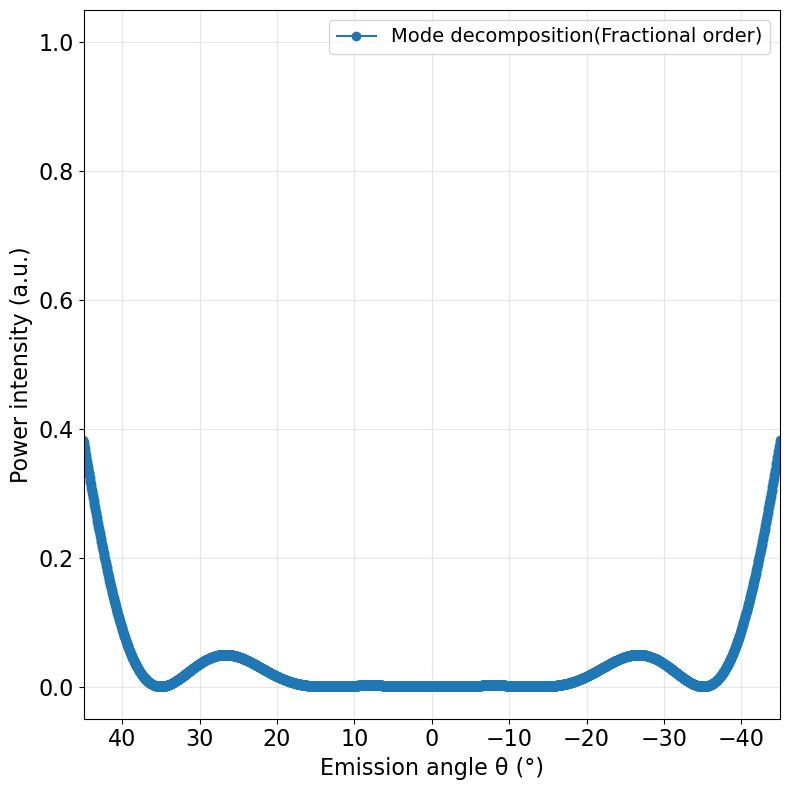

In [156]:

plt.figure(figsize=(8,8))
plt.plot(theta_masked, P_theta/max(P_theta), 'o-', label = 'Mode decomposition(Fractional order)')
# plt.plot(angle_sel,Pr_sel, 'r-', label = 'N2F - 360 points')

plt.xlim(theta_min_deg if USE_ANGLE_MASK else -90, theta_max_deg if USE_ANGLE_MASK else 90)
plt.xlabel("Emission angle θ (°)", fontsize = 16)
plt.ylabel("Power intensity (a.u.)",fontsize = 16)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlim(45, -45)

plt.grid(True, alpha=0.3)
plt.legend(loc = 'upper right', fontsize = 14)
plt.tight_layout()
plt.show()